In [3]:
import numpy as np
import pandas as pd 
import os
import sys
import cv2 

import os
import datetime
import copy
import re
import yaml
import uuid
import warnings
import time
import inspect

from torch.autograd import Variable
from os.path import join
from glob import glob
from skimage.transform import resize
import skimage.io as io
from C3D_model import C3D

import torch
from torch import nn, optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from torchvision.models import resnet
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST
import tensorflow as tf
from tqdm.autonotebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import metrics as mtx
from sklearn import model_selection as ms

In [12]:
!pwd

/home/modeling/UCF_CRIME/script


In [13]:
# current_dir = 'home/modeling/UCF_CRIME/script/'
BASE_PATH = '/home/modeling/UCF_CRIME' 
DATA_PATH = os.path.join(BASE_PATH, 'data')
VIDEO_PATH = os.path.join(DATA_PATH, 'video')
ANNOTATION_PATH = os.path.join(DATA_PATH, 'annotation')
TEST_ANNOTATION_PATH = os.path.join(ANNOTATION_PATH, 'Anomaly_Test.csv')

In [14]:
assert os.path.exists(TEST_ANNOTATION_PATH)

In [104]:
from C3D_model import C3D

In [170]:
net = C3D()

net.cuda()
net.eval()
torch.set_grad_enabled(False)

In [25]:
clip = sorted(glob(join('data', 'roger', '*.png')))

### confustion matrix test 

In [31]:
from sklearn.metrics import confusion_matrix

In [28]:
y_pred = [1, 1, 2, 2, 0]
y_test = [1, 0, 1, 1, 2] 

In [32]:
confusion_matrix(y_test, y_pred)

array([[0, 1, 0],
       [0, 1, 2],
       [1, 0, 0]])

### Test Dataset 

In [81]:
TEST_DATA_PATH = '/home/modeling/UCF_CRIME/data/data/TEST_DATA'
ANNOTATION_PATH = '/home/modeling/UCF_CRIME/data/annotation' 

In [82]:
columns = ['name']

In [83]:
test_video = pd.read_csv(os.path.join(ANNOTATION_PATH, 'test_video.csv'), header=None, names=columns)

In [84]:
test_video.head()

,name
0,Arson/Arson022_x264.mp4 3500 4000 0
1,Stealing/Stealing036_x264.mp4 1260 1590 2
2,Arson/Arson018_x264.mp4 270 600 0
3,Arson/Arson011_x264.mp4 150 420 0
4,Assault/Assault011_x264.mp4 375 960 1


In [159]:
clips = ['/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/0.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/1.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/10.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/100.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/101.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/102.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/103.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/104.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/105.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/106.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/107.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/108.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/109.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/11.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/110.png', '/home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264/111.png']

In [155]:
predict_clips(clips, 1)

[2] 2


In [172]:
pred_label = [] 
test_label = [] 

In [173]:
def predict_label(image_path, label, file_length):
    files = sorted(glob(join(image_path,'*.png')))
    image_list = []    # 16 frames 
    
    # print(len(files), file_length)

    for i in range(0, file_length):
        image_list.append(files[i])
        
        if len(image_list) != 16:   # 마지막 16 이하 프레임들은 처리 x 
            continue 
        
        if len(image_list) == 16:     
            predict_clips(image_list, label)
            image_list = []           

In [174]:
# 16개 이미지 리스트를 입력받아 데이터를 처리하고 예측 수행 
def predict_clips(clip, label, verbose=True):   # clip: [1.png, 2.png, ..., 15.png]
    global test_label
    global pred_label 
    global net
    
    clip = np.array([resize(io.imread(frame), output_shape=(112, 200), preserve_range=True) for frame in clip])
    clip = clip[:, :, 44:44+112, :]  # crop centrally
    if verbose:
        clip_img = np.reshape(clip.transpose(1, 0, 2, 3), (112, 16 * 112, 3))
    
    clip = clip.transpose(3, 0, 1, 2)  # ch, fr, h, w
    clip = np.expand_dims(clip, axis=0)  # batch axis
    clip = np.float32(clip)
    
    X = torch.from_numpy(clip)
    X = Variable(X)
    X = X.cuda()
    
    prediction = net(X)
    prediction = prediction.data.cpu().numpy()
    top_inds = prediction[0].argsort()[::-1][:1]
    # print(top_inds, top_inds[0])
    pred_label.append(top_inds[0])
    test_label.append(label)

In [175]:
def return_idx(ab_type):
    if ab_type == 'Arson':
        return 0
    elif ab_type == 'Assault':
        return 1 
    elif ab_type == 'Stealing':
        return 2 
    elif ab_type == 'Training_Normal_Videos_Anomaly' or ab_type == 'Testing_Normal_Videos_Anomaly':
        return 3 

In [176]:
for data in test_video['name']:
    folder = data.split()[0].split('.')[0]   # Arson/Arson022_x264 
    label = return_idx(folder.split('/')[0])   # 0, 1, 2 
    image_path = os.path.join(TEST_DATA_PATH, folder)   # home/modeling/UCF_CRIME/data/data/TEST_DATA/Arson/Arson022_x264
    file_length = int(data.split()[2]) - int(data.split()[1])
    if file_length == 6911:
        file_length -= 1 
    elif file_length == 796:
        file_length -= 2 
    predict_label(image_path, label, file_length)

In [177]:
len(pred_label), len(test_label)

(1255, 1255)

In [178]:
print(pred_label)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 1, 0, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1, 2, 2, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 1, 2, 0, 1, 0, 1, 2, 1, 2, 2, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 

In [179]:
print(test_label)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

### 혼동 행렬 그리기

In [184]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

In [197]:
from matplotlib import font_manager, rc 
import platform
import matplotlib.pyplot as plt 

if platform.system() == 'Windows':
    path = 'c:\Windows\Fonts\malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font',faimly='AppleGothic')
else:
    print('Check your OS system')

Check your OS system


In [198]:
cm = confusion_matrix(test_label, pred_label)

In [200]:
df_cm = pd.DataFrame(cm, index=['Arson', 'Assault', 'Stealing'], columns= ['Arson', 'Assault', 'Stealing'] )

In [201]:
df_cm

,Arson,Assault,Stealing
Arson,21,248,198
Assault,129,227,132
Stealing,42,79,179


<AxesSubplot:title={'center':'Abnormal Detection Confusion Matrix'}>

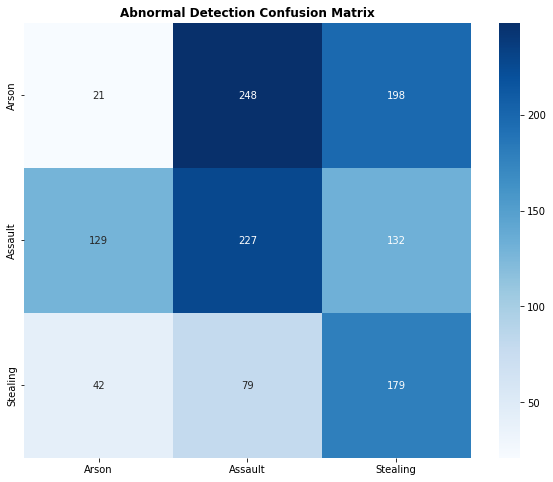

In [203]:
plt.figure(figsize=(10, 8))

plt.title('Abnormal Detection Confusion Matrix', fontweight="bold")
sns.heatmap(df_cm, cmap='Blues', fmt='d', annot=True)